# Damped harmonic oscillator

## x fixed nodes

Formula of damped harmonic oscillator

$$ x(t) = A_0 e^{\frac{-b}{2t}} \cos(\sqrt{\kappa - \frac{b^2}{4}} t + \delta_0) $$

$$ A_0 = 1, \\
\delta_0 = 0, \\
b \in [0.5, 1], \\
\kappa \in [5, 10]. $$

for 100000 random values of $b$ and $\kappa$.

We train reconstructing with x time points. To do this, we ask x questions at fixed times $t_{meas}$ between 0s and 5s. This leads to x answer as output.

## Imports

In [1]:
from google.colab import drive

drive.mount('/content/drive')

path = "/content/drive/My Drive/PhD year 1/BETA oscillator/"

import sys
sys.path.insert(0, path) # To import module scinet

Mounted at /content/drive


In [2]:
!pip install wandb
from scinet import *
import scinet.ed_oscillator_fixed as edo

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 180 kB 43.0 MB/s 
     |████████████████████████████████| 97 kB 5.8 MB/s 
     |████████████████████████████████| 140 kB 49.0 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=5fe0cf2f4e516f133a2d3a270b8033c7692043cad24b5659ce8fd862713dc153
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=e6fac78e36aab775b91272b912e15c436230c07d042efebbcbe49a981d4cb227
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


## Data creation and loading

In [3]:
# Create data
create_data = False
output_nodes_list = [1, 2, 5, 10, 25, 50]
if create_data:
    for output_nodes in output_nodes_list:
        edo.oscillator_data(N=100000, output_nodes=output_nodes, seed=0,
                            fileName=f'oscillator fixed/oscillator_{output_nodes}');
        print(f"Created data for {output_nodes} output nodes!")
else:
    print("Data already created!")

Data already created!


In [4]:
# Load data
output_nodes = 1
td, vd, ts, vs, proj = dl.load(5, f'oscillator fixed/oscillator_{output_nodes}')
print(f"Train: {td[0].shape[0]} samples, validation: {vd[0].shape[0]} samples\n")
print(f"Shapes (x_in, t_meas, x_out) = {[td[i].shape for i in [0, 1, 2]]}")
print(f"Shapes (A_0, delta, b, k) = {[ts[:, i].shape for i in [0, 1, 2, 3]]}")

Train: 95000 samples, validation: 5000 samples

Shapes (x_in, t_meas, x_out) = [(95000, 50), (95000, 1), (95000, 1)]
Shapes (A_0, delta, b, k) = [(95000,), (95000,), (95000,), (95000,)]


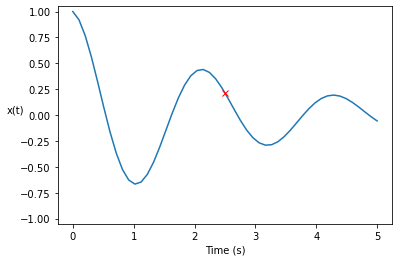

(A_0, delta, b, k) = [1.0, 0.0, 0.7644474598764522, 8.590930161584707]

t_meas = [2.5]


In [5]:
# Plot the first training sample td[:][0]
import matplotlib.pyplot as plt
import numpy as np

t_sample = np.linspace(0, 5, 50)
sample_idx = 11
x_in = td[0][sample_idx]
t_meas = td[1][sample_idx]
x_out = td[2][sample_idx]

plt.plot(t_sample, x_in, label='x_in');
plt.plot(t_meas, x_out, 'rx', label='x_out')
plt.xlabel('Time (s)')
plt.ylabel('x(t)', rotation=0)
plt.ylim([-1.05, 1.05])
#plt.legend()
plt.show()

print(f"(A_0, delta, b, k) = {[ts[sample_idx, i] for i in [0, 1, 2, 3]]}\n")
print(f"t_meas = {t_meas}")

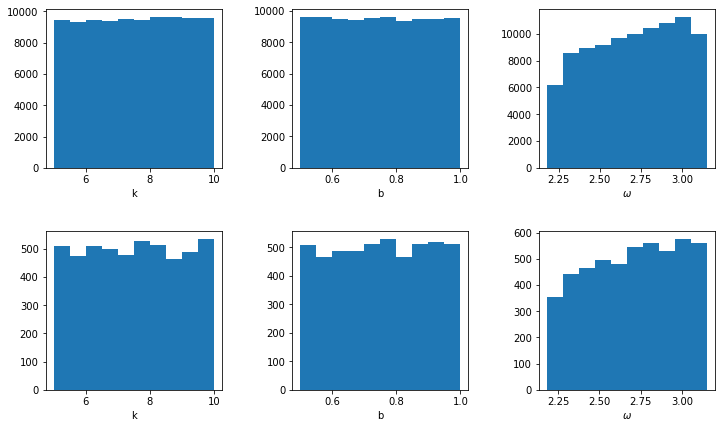

In [6]:
# Plot distributions of k, b and omega

plt.figure(figsize=(12, 7))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for row, data in enumerate([ts, vs]):
    k = data[:, 3]
    b = data[:, 2]
    omega = np.sqrt(k - (b**2/4))
    
    # Plot k hist
    plt.subplot(2, 3, 1 + row*3)
    plt.hist(k)
    plt.xlabel('k')
    
    # Plot b hist
    plt.subplot(2, 3, 2 + row*3)
    plt.hist(b)
    plt.xlabel('b')
    
    # Plot omega hist
    plt.subplot(2, 3, 3 + row*3)
    plt.hist(omega)
    plt.xlabel(r'$\omega$')
    
plt.show()

## Create and train neural network

In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import tensorflow as tf

# create and train network
seed_list = [0]
output_nodes_list = [1, 2, 5, 10, 25, 50]

for seed in seed_list: 
    for output_nodes in output_nodes_list:
        print(f"Training network with {output_nodes} output nodes...")
        run = wandb.init(project="Oscillator fixed output nodes swish",
                         config={
                             "output_nodes": output_nodes,
                             "latent_dim": 10,
                             "epochs": 150, 
                             "beta": 0.001, 
                             "seed": seed})
        config = wandb.config

        td, vd, ts, vs, proj = dl.load(5, f'oscillator fixed/oscillator_{config.output_nodes}')

        net = nn.Network(input_size=50, latent_size=10, 
                         input2_size=config.output_nodes, output_size=config.output_nodes,
                         seed=config.seed, activation=tf.keras.activations.swish, wandblog=True)

        #def train(epoch_num, batch_size, learning_rate, training_data, validation_data, **kwargs)
        net.train(config.epochs, 250, 0.001, td, vd)
        net.save(f'oscillator fixed swish/oscillator_{config.output_nodes}_seed_{config.seed}')

    # end wandb run
    run.join()

Training network with 1 output nodes...


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator fixed swish/oscillator_1_seed_0
Training network with 2 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,█▄█▅▄▇▆▄▃▅▅▄▃▃▅▅▅▃▄▃▃▃▅▄▅▃▁▂▅▄▃▂▄▃▃▃▄▃▄▃
mae_test,▅▆█▃▄▆▂▄▃▃▁▄▂▃▃▂▄▂▃▃▂▃▁▂▃▁▂▂▁▂▁▂▃▂▁▂▂▁▂▂
recon_loss_train,▄▆█▂▃▅▁▃▂▂▁▂▁▂▂▂▃▁▂▂▁▂▁▁▂▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁
total_loss_train,▅▅█▂▃▅▂▃▂▂▂▃▁▂▂▂▃▁▂▂▁▂▂▂▃▁▁▁▂▂▁▁▂▁▁▂▁▁▂▁
epoch,150
kl_divergence_train,1.69485
mae_test,0.00401
recon_loss_train,3e-05
total_loss_train,0.00172


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator fixed swish/oscillator_2_seed_0
Training network with 5 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,█▂▄▄▄▅▄▄▄▃▇▂▄▂▂▁▂▁▃▂▃▃▁▂▄▃▂▁▃▃▂▁▄▃▃▅▃▂▃▂
mae_test,▆█▄▃▂█▄▄▃▂▃▄▃▂▂▃▂▂▂▁▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▂▂▁
recon_loss_train,▆█▄▃▂▇▅▅▂▂▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▂▂▁
total_loss_train,▇█▄▃▃█▆▅▂▂▄▄▃▂▁▂▁▁▂▁▁▁▁▁▂▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁
epoch,150
kl_divergence_train,1.73732
mae_test,0.01251
recon_loss_train,0.00028
total_loss_train,0.00202


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator fixed swish/oscillator_5_seed_0
Training network with 10 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,█▃▁▂▁▂▂▂▂▂▂▂▃▂▂▃▂▃▂▁▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▃▂
mae_test,▆▄▅█▅▆█▆▂▃▃▇▃▂▂▂▂▁▂▃▂▂▂▁▁▁▂▁▁▁▁▂▂▂▂▁▁▂▂▂
recon_loss_train,█▄▅█▅▅█▅▂▂▂▇▂▂▁▂▂▁▂▃▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▂▁
total_loss_train,█▄▃▅▃▃▅▄▂▂▂▄▂▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁
epoch,150
kl_divergence_train,1.6117
mae_test,0.01241
recon_loss_train,0.00031
total_loss_train,0.00192


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator fixed swish/oscillator_10_seed_0
Training network with 25 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,█▅▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▂▁▂▂▂▂▁▂▁▁▂▂▁▂▁
mae_test,▇▅▇█▅▄▃▃▃▃▂▂▃▃▂▂▃▁▃▂▂▂▂▂▃▁▂▂▂▂▁▁▂▂▁▁▁▂▁▂
recon_loss_train,▇▄▇█▄▃▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,█▅▅▆▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,2.39092
mae_test,0.00935
recon_loss_train,0.00015
total_loss_train,0.00254


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator fixed swish/oscillator_25_seed_0
Training network with 50 output nodes...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,█▅▃▃▃▃▃▂▃▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁
mae_test,██▅▅▄▃▂▃▂▅▂▂▂▂▂▂▁▂▃▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁
recon_loss_train,█▇▃▄▃▂▂▂▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,█▆▃▄▃▂▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,2.48028
mae_test,0.00884
recon_loss_train,0.00014
total_loss_train,0.00262


  0%|          | 0/150 [00:00<?, ?it/s]

Working on epoch 10...
Finished epoch 10!

Working on epoch 20...
Finished epoch 20!

Working on epoch 30...
Finished epoch 30!

Working on epoch 40...
Finished epoch 40!

Working on epoch 50...
Finished epoch 50!

Working on epoch 60...
Finished epoch 60!

Working on epoch 70...
Finished epoch 70!

Working on epoch 80...
Finished epoch 80!

Working on epoch 90...
Finished epoch 90!

Working on epoch 100...
Finished epoch 100!

Working on epoch 110...
Finished epoch 110!

Working on epoch 120...
Finished epoch 120!

Working on epoch 130...
Finished epoch 130!

Working on epoch 140...
Finished epoch 140!

Working on epoch 150...
Finished epoch 150!

Saved network to file oscillator fixed swish/oscillator_50_seed_0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_divergence_train,█▅▄▃▃▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁
mae_test,█▅▄▄▅▂▂▂▃▂▂▂▂▃▂▂▁▂▂▃▁▂▂▁▂▂▁▁▁▁▂▂▂▁▂▁▁▁▁▁
recon_loss_train,█▄▃▃▃▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss_train,█▄▃▃▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
kl_divergence_train,2.51008
mae_test,0.00846
recon_loss_train,0.00012
total_loss_train,0.00264


## Show predictions

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator fixed swish/oscillator_5_seed_0.ckpt
Loaded network from file oscillator fixed swish/oscillator_5_seed_0
MAE on validation set: 0.012409080936335677
t_meas: [0.   1.25 2.5  3.75 5.  ], x_out: [ 1.         -0.48946802  0.1859754  -0.03855457 -0.01678227]
t_meas: [0.   1.25 2.5  3.75 5.  ], x_out: [ 1.         -0.46356694  0.06621069  0.10715654 -0.1234212 ]
t_meas: [0.   1.25 2.5  3.75 5.  ], x_out: [ 1.         -0.68849961  0.45017126 -0.2770869   0.1574117 ]
t_meas: [0.   1.25 2.5  3.75 5.  ], x_out: [ 1.         -0.5990772   0.35821402 -0.21378374  0.12734186]
t_meas: [0.   1.25 2.5  3.75 5.  ], x_out: [ 1.         -0.6454284   0.40411766 -0.24474474  0.14254859]
t_meas: [0.   1.25 2.5  3.75 5.  ], x_out: [ 1.         -0.43964355  0.08000222  0.0644369  -0.08118487]


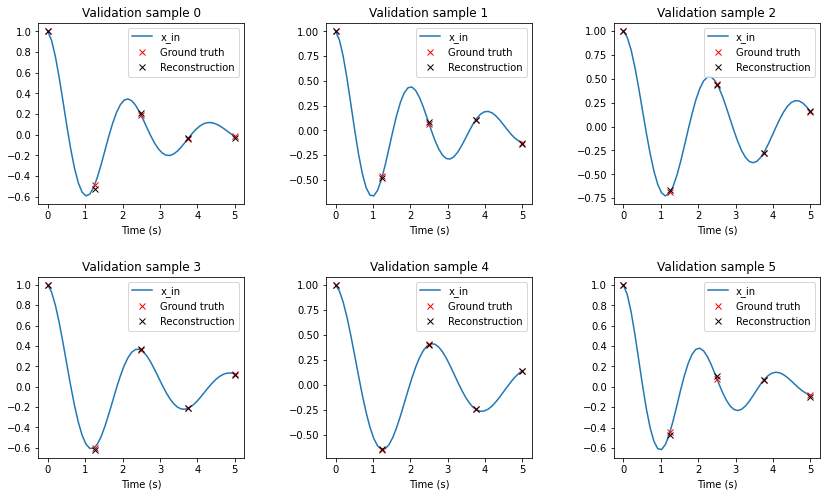

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

output_nodes = 5
seed = 0
td, vd, ts, vs, proj = dl.load(5, f'oscillator fixed/oscillator_{output_nodes}')

# Load network
net = nn.Network(input_size=50, latent_size=10, 
                 input2_size=output_nodes, output_size=output_nodes,
                 seed=0, activation=tf.keras.activations.swish,
                 wandblog=True, load_file=f"oscillator fixed swish/oscillator_{output_nodes}_seed_{seed}")

t_sample = np.linspace(0, 5, 50)
x_pred = net.run(vd, layer=net.output)
mae = tf.keras.losses.mean_absolute_error(x_pred.reshape(-1), vd[2].reshape(-1))
print(f"MAE on validation set: {mae}")

plt.figure(figsize=(14, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, sample_idx in enumerate([0, 1, 2, 3, 4, 5]):
    
    x_in = vd[0][sample_idx]
    t_meas = vd[1][sample_idx]
    x_out = vd[2][sample_idx]
    
    b = vs[sample_idx][2]
    k = vs[sample_idx][3]
        
    plt.subplot(2, 3, i+1)
    plt.plot(t_sample, x_in, label='x_in');
    plt.plot(t_meas, x_out, 'rx', label='Ground truth')
    print(f"t_meas: {t_meas}, x_out: {x_out}")
    plt.plot(t_meas, x_pred[sample_idx], 'kx', label='Reconstruction')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.title(f"Validation sample {sample_idx}")
    
plt.show()

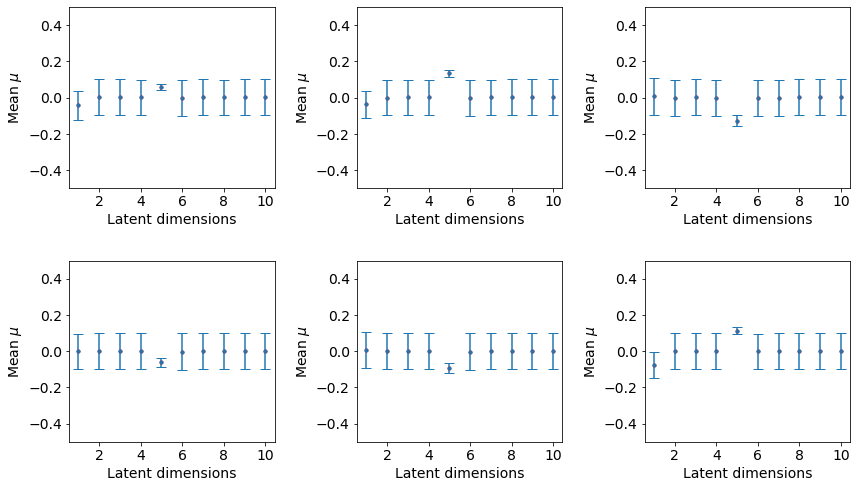

In [9]:
# Plot latent dimensions of above reconstructions

mu_all, logvar_all, z_all = net.run(vd, layer=net.mu), tf.exp(net.run(vd, layer=net.log_sigma)), net.run(vd, layer=net.mu_sample)

plt.figure(figsize=(14, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, sample_idx in enumerate([0, 1, 2, 3, 4, 5]):
    
    mu = mu_all[sample_idx]
    logvar = logvar_all[sample_idx]
    z = z_all[sample_idx]
    
    plt.subplot(2, 3, i+1)
    plt.errorbar([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], mu, 
                 yerr=logvar, marker=".", ls=" ", capsize=5)
    plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], z, 'r.')
    
    plt.xlabel("Latent dimensions", fontsize=14)
    plt.ylabel("Mean $\mu$", fontsize=14)
    plt.ylim([-0.5, 0.5])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.show()

Dimension 1: cov_mu=0.001679267950801021
Latent dimension 1 is active!
Dimension 2: cov_mu=3.525039045995403e-07
Dimension 3: cov_mu=4.2390599397271195e-07
Dimension 4: cov_mu=9.398419328947261e-07
Dimension 5: cov_mu=0.00929321599849229
Latent dimension 5 is active!
Dimension 6: cov_mu=3.95418814024096e-07
Dimension 7: cov_mu=6.915090234106885e-07
Dimension 8: cov_mu=3.5264692111708687e-07
Dimension 9: cov_mu=5.329611343362014e-07
Dimension 10: cov_mu=4.479521179901711e-07
There are 2 active latent dimensions!


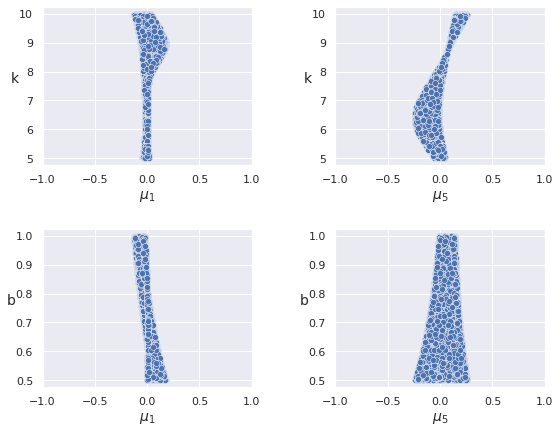

In [10]:
# Plot the occupied latent dimensions 8 and 9
import seaborn as sns
sns.set(style="darkgrid")

mu_train, logvar_train, z_train = net.run(td, layer=net.mu), tf.exp(net.run(td, layer=net.log_sigma)), net.run(td, layer=net.mu_sample)
mu_val, logvar_val, z_val = net.run(vd, layer=net.mu), tf.exp(net.run(vd, layer=net.log_sigma)), net.run(vd, layer=net.mu_sample)

k_train = ts[:, 3]
b_train = ts[:, 2]
k_val = vs[:, 3]
b_val = vs[:, 2]

# Compute Activated Units (AU) using cov(mu)
active_dims = []
treshold = 0.001 # was 0.01 in other experiment
for i in range(10):
    cov_mu = np.cov(z_train[:, i])
    print(f"Dimension {i+1}: cov_mu={cov_mu}")
    if cov_mu > treshold:
        print(f"Latent dimension {i+1} is active!")
        active_dims.append(i + 1) 
print(f"There are {len(active_dims)} active latent dimensions!")
    
# Create scatterplots
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for row, par in enumerate([k_train, b_train]):
    for i in range(2):
        if len(active_dims) == 2:
            dim = active_dims
        elif len(active_dims) == 1:
            dim = active_dims + [10]
        else:
            dim = [9, 10]
        ax = axs.reshape(-1)[i + row*2]
        sns.scatterplot(x=z_train[:, dim[i] - 1], y=par, palette="RdBu",  ax=ax)
        ax.set_xlim([-1, 1])
        
        # Set x label
        if dim[i] == 10:
            ax.set_xlabel(r"$\mu_{10}$", fontsize=14)
        else:
            ax.set_xlabel(f"$\mu_{dim[i]}$", fontsize=14)
            
        # Set y label
        if row == 0:
            ax.set_ylabel("k", rotation='horizontal', fontsize=14)
        elif row == 1:
            ax.set_ylabel("b", rotation='horizontal', fontsize=14)

fig.show()

In [11]:
def save_correlation(output_nodes=5):
  print(f"k shape: {k_train.shape}")
  print(f"b shape: {b_train.shape}")
  print(f"mean shape: {z_train.shape}")
  correlation = np.concatenate([k_train.reshape(-1, 1), b_train.reshape(-1, 1), z_train], axis=1)
  print(f"correlation shape: {correlation.shape}")
  np.save(path + f"correlation_fixed_output_nodes={output_nodes}.npy",
          correlation)

save_correlation(output_nodes=5)

k shape: (95000,)
b shape: (95000,)
mean shape: (95000, 10)
correlation shape: (95000, 12)


## Active Units (AU) and simplifying table

In [ ]:
import pandas as pd

# Get row in table for net with given output nodes
def get_row(output_nodes, seed, activation='swish'):
    td, vd, ts, vs, proj = dl.load(5, f'oscillator fixed/oscillator_{output_nodes}')

    # Load network
    if activation=='swish':
      act_fun = tf.keras.activations.swish
    elif activation=='ELU':
      act_fun = tf.nn.elu
    else:
      print(f"Activation {activation} not valid")
      return
    net = nn.Network(input_size=50, latent_size=10, 
                     input2_size=output_nodes, output_size=output_nodes,
                     seed=0, activation=act_fun,
                     wandblog=True, load_file=f"oscillator fixed {activation}/oscillator_{output_nodes}_seed_{seed}");

    mu_train, logvar_train, z_train = net.run(td, layer=net.mu), tf.exp(net.run(td, layer=net.log_sigma)), net.run(td, layer=net.mu_sample)
    mu_val, logvar_val, z_val = net.run(vd, layer=net.mu), tf.exp(net.run(vd, layer=net.log_sigma)), net.run(vd, layer=net.mu_sample)

    # Compute Activated Units (AU) using cov(mu)
    active_dims = 0
    treshold = 0.001 # was 0.01 in other experiment, 
    for i in range(10):
        cov_mu = np.cov(z_train[:, i])
        if cov_mu > treshold:
            print(f"Latent dimension {i+1} is active!")
            active_dims += 1
    print(f"There are {active_dims} active latent dimensions!")
    
    # Compute test MAE
    x_pred = net.run(vd, layer=net.output)
    mae_test = tf.keras.losses.mean_absolute_error(x_pred.reshape(-1), vd[2].reshape(-1))
    
    # Compute KL div
    kl_div = net.run(vd, layer=net.kl_loss)
    
    # Put data in panda row
    row = pd.Series(index=['Output nodes', 'Seed', 'Test MAE', 
                           'KL div', 'Active Units'],
                    data=[int(output_nodes), seed, mae_test.numpy(), 
                          kl_div, int(active_dims)])
    
    return row

res = get_row(output_nodes=2, seed=0, activation='swish')
print(res)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator fixed swish/oscillator_2_seed_0.ckpt
Loaded network from file oscillator fixed swish/oscillator_2_seed_0
Latent dimension 3 is active!
Latent dimension 5 is active!
There are 2 active latent dimensions!
Output nodes    2.000000
Seed            0.000000
Test MAE        0.012513
KL div          1.737270
Active Units    2.000000
dtype: float64


In [ ]:
# Create simple table from different rows
def create_simple_table():
    simple_table = pd.DataFrame(columns=['Output nodes', 'Seed', 'Test MAE',
                                         'KL div', 'Active Units'])
    simple_table.to_csv(io.data_path + 'simple_table_fixed_swish.csv')

def add_row(output_nodes_list):
    simple_table = load_simple_table()

    for output_nodes in output_nodes_list:
        for seed in [0]:
            row = get_row(output_nodes=output_nodes, seed=seed, activation='swish')
            simple_table = simple_table.append(row, ignore_index=True)
    simple_table.to_csv(io.data_path + 'simple_table_fixed_swish.csv')
    return simple_table

def load_simple_table():
    simple_table = pd.read_csv(io.data_path + 'simple_table_fixed_swish.csv', index_col=0)
    return simple_table

create_simple_table()
simple_table = add_row(output_nodes_list=[1, 2, 5, 10, 25, 50])
simple_table

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator fixed swish/oscillator_1_seed_0.ckpt
Loaded network from file oscillator fixed swish/oscillator_1_seed_0
Latent dimension 6 is active!
There are 1 active latent dimensions!
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator fixed swish/oscillator_2_seed_0.ckpt
Loaded network from file oscillator fixed swish/oscillator_2_seed_0
Latent dimension 3 is active!
Latent dimension 5 is active!
There are 2 active latent dimensions!
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator fixed swish/oscillator_5_seed_0.ckpt
Loaded network from file oscillator fixed swish/oscillator_5_seed_0
Latent dimension 1 is active!
Latent dimension 5 is active!
There are 2 active latent dimensions!
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA osc

,Output nodes,Seed,Test MAE,KL div,Active Units
0,1.0,0.0,0.004010,1.690260,1.0
1,2.0,0.0,0.012513,1.737270,2.0
2,5.0,0.0,0.012409,1.609807,2.0
3,10.0,0.0,0.009353,2.390584,2.0
4,25.0,0.0,0.008842,2.480394,2.0
5,50.0,0.0,0.008462,2.509258,2.0


In [ ]:
simple_table = pd.read_csv(io.data_path + 'simple_table_fixed_swish.csv', index_col=0)
simple_table

,Output nodes,Seed,Test MAE,KL div,Active Units
0,1.0,0.0,0.004010,1.690260,1.0
1,2.0,0.0,0.012513,1.737270,2.0
2,5.0,0.0,0.012409,1.609807,2.0
3,10.0,0.0,0.009353,2.390584,2.0
4,25.0,0.0,0.008842,2.480394,2.0
5,50.0,0.0,0.008462,2.509258,2.0


In [ ]:
simple_table.to_latex(index=False)

'\\begin{tabular}{rrrrr}\n\\toprule\n Output nodes &  Seed &  Test MAE &    KL div &  Active Units \\\\\n\\midrule\n          1.0 &   0.0 &  0.004010 &  1.690260 &           1.0 \\\\\n          2.0 &   0.0 &  0.012513 &  1.737270 &           2.0 \\\\\n          5.0 &   0.0 &  0.012409 &  1.609807 &           2.0 \\\\\n         10.0 &   0.0 &  0.009353 &  2.390584 &           2.0 \\\\\n         25.0 &   0.0 &  0.008842 &  2.480394 &           2.0 \\\\\n         50.0 &   0.0 &  0.008462 &  2.509258 &           2.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
simple_table = pd.read_csv(path + 'simple_table_fixed.csv', index_col=0)

mean_table = simple_table.groupby(['Output nodes']).mean()[['Test MAE', 'KL div', 'Active Units']]
std_table = simple_table.groupby(['Output nodes']).std()[['Test MAE', 'KL div', 'Active Units']]
print(mean_table)
print(std_table)

              Test MAE    KL div  Active Units
Output nodes                                  
1.0           0.004395  1.702213           1.0
2.0           0.014505  1.749647           2.0
5.0           0.013216  1.629546           2.0
10.0          0.012268  2.432677           2.0
25.0          0.010370  2.479435           2.0
50.0          0.010640  2.510633           2.0
              Test MAE    KL div  Active Units
Output nodes                                  
1.0           0.001321  0.033119           0.0
2.0           0.000756  0.036233           0.0
5.0           0.001119  0.011107           0.0
10.0          0.001309  0.008296           0.0
25.0          0.000404  0.024134           0.0
50.0          0.001136  0.023628           0.0


In [ ]:
# Convert table to clean latex
mean_table.to_latex(index=False)

'\\begin{tabular}{rrr}\n\\toprule\n Test MAE &    KL div &  Active Units \\\\\n 0.004395 &  1.702213 &           1.0 \\\\\n\\midrule\n 0.014505 &  1.749647 &           1.0 \\\\\n 0.013216 &  1.629546 &           1.0 \\\\\n 0.012268 &  2.432677 &           2.0 \\\\\n 0.010370 &  2.479435 &           2.0 \\\\\n 0.010640 &  2.510633 &           2.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/PhD year 1/BETA oscillator/tf_save/oscillator fixed/oscillator_50_seed_0.ckpt
Loaded network from file oscillator fixed/oscillator_50_seed_0
vd shape = [(5000, 50), (5000, 50), (5000, 50)]
samples shape = [(6, 50), (6, 50), (6, 50)]
MAE on validation set: 0.011619342805226083


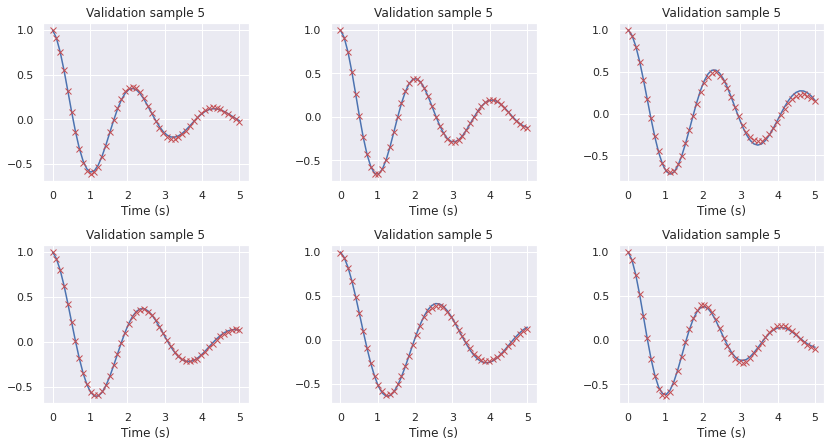

In [ ]:
# Reconstruct full time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

t_sample = np.linspace(0, 5, 50)
output_nodes = 50
seed = 0
td, vd, ts, vs, proj = dl.load(5, f'oscillator fixed/oscillator_{output_nodes}')
net = nn.Network(input_size=50, latent_size=10, 
                 input2_size=output_nodes, output_size=output_nodes,
                 seed=0, load_file=f"oscillator fixed/oscillator_{output_nodes}_seed_{seed}");

# Make samples like vd for j samples, 50 rows for each data point t in [0, 5]
x_in_list = list()
t_meas_list = list()
x_out_list = list()

for j in range(6):
    for i in range(int(50 / output_nodes)):
        # Make array of x_in, same for 50 rows
        x_in_list.append(vd[0][j])
    
        # Make array of t_meas, 50 / output_nodes times t in [0, 5] for 50 / output_nodes rows
        t_meas_list.append([t_sample[output_nodes*i + k] for k in range(output_nodes)])
    
        # Make array of x_out
        x_out_list.append([vd[0][j][output_nodes*i + k] for k in range(output_nodes)])

samples = [np.array(x_in_list), np.array(t_meas_list), np.array(x_out_list)]
print(f"vd shape = [{vd[0].shape}, {vd[1].shape}, {vd[2].shape}]")
print(f"samples shape = [{samples[0].shape}, {samples[1].shape}, {samples[2].shape}]")

# Make predictions on samples
x_pred = net.run(samples, layer=net.output)

# Mae on 6 validation samples
mae = tf.keras.losses.mean_absolute_error(x_pred.reshape(-1), samples[2].reshape(-1))
print(f"MAE on validation set: {mae}")

plt.figure(figsize=(14, 7))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i in [0, 1, 2, 3, 4, 5]:
    
    # Get x_in in case output_nodes=2, for 0, 25, 50...
    x_in = samples[0][i * int(50 / output_nodes)]
    
    plt.subplot(2, 3, i+1)
    plt.plot(t_sample, x_in);
    plt.plot(t_sample, [x_pred.reshape(-1)[i*50 + j] for j in range(50)], 'rx')
    plt.xlabel('Time (s)')
    plt.title(f"Validation sample {sample_idx}")
    
plt.show()